# Spaceship Titanic

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

**train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.**
* `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
* `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* `Destination` - The planet the passenger will be debarking to.
* `Age`- The age of the passenger.
* `VIP` - Whether the passenger has paid for special VIP service during the voyage.
* `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* `Name` - The first and last names of the passenger.
* `Transported` - Whether the passenger was transported to another dimension. This is the `target`, the column you are trying to predict.
**test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.Your task is to predict the value of Transported for the passengers in this set.**
**sample_submission.csv - A submission file in the correct format.**
* `PassengerId` - Id for each passenger in the test set.
* `Transported` - The target. For each passenger, predict either True or False.

Metrics: `accuracy`


# Data overview

In [1]:
# Import all the tools
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
# from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

train = pd.read_csv("/home/mikhail/data/Spaceship_Titanic/train.csv")
test = pd.read_csv("/home/mikhail/data/Spaceship_Titanic/test.csv")
sub = pd.read_csv('/home/mikhail/data/Spaceship_Titanic/sample_submission.csv')

# plots inside the notebook
%matplotlib inline
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    train.shape, train.isna().sum().sum(), train.duplicated().sum()))
print('Test Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    test.shape, test.isna().sum().sum(), test.duplicated().sum()))
train_d = train.drop_duplicates()

if train.shape == train_d.shape:
    print('No duplicates')
else:
    print('Dropping Duplicates\nNew Train Shape: {}'.format(train_d.shape))

Train Shape: (8693, 14)
Missing Data: 2324
Duplicates: 0

Test Shape: (4277, 13)
Missing Data: 1117
Duplicates: 0

No duplicates


In [2]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [3]:
test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


This is a classificataion task with two classes: 1 or 0. Let's encode the target value

In [4]:
train['Transported'] = train['Transported'].astype(int)
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0


# EDA & FE

In [5]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported       int64
dtype: object

In [6]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

## Target

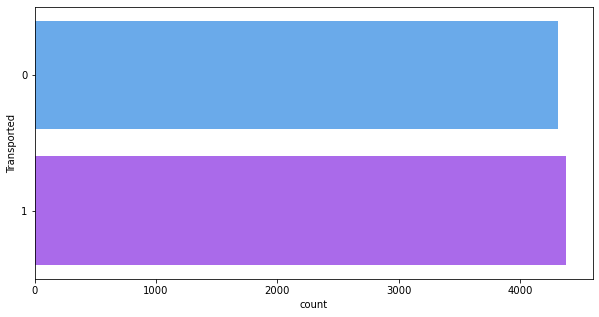

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(y=train['Transported'], palette='cool', orient='h')
plt.show()

## Create features

In [9]:
# y = train['Transported']
# train.drop('Transported',axis=1, inplace=True)

train['Ageismissing'] = train['Age'].isnull()
train['Ageismissing'] = train['Ageismissing'].astype(int)
train['Age'].fillna(train['Age'].mean(), inplace=True)
test['Ageismissing'] = test['Age'].isnull()
test['Ageismissing'] = test['Ageismissing'].astype(int)
test['Age'].fillna(test['Age'].mean(), inplace=True)

train['RoomService'].fillna(0, inplace=True)
test['RoomService'].fillna(0, inplace=True)
train['PaidRoomService'] = train['RoomService'] > 0
train['PaidRoomService'] = train['PaidRoomService'].astype(int)
test['PaidRoomService'] = test['RoomService'] > 0
test['PaidRoomService'] = test['PaidRoomService'].astype(int)

train['FoodCourt'].fillna(0, inplace=True)
test['FoodCourt'].fillna(0, inplace=True)
train['PaidFoodCourt'] = train['FoodCourt'] > 0
train['PaidFoodCourt'] = train['PaidFoodCourt'].astype(int)
test['PaidFoodCourt'] = test['FoodCourt'] > 0
test['PaidFoodCourt'] = test['PaidFoodCourt'].astype(int)

train['ShoppingMall'].fillna(0, inplace=True)
test['ShoppingMall'].fillna(0, inplace=True)
train['PaidShoppingMall'] = train['ShoppingMall'] > 0
train['PaidShoppingMall'] = train['PaidShoppingMall'].astype(int)
test['PaidShoppingMall'] = test['ShoppingMall'] > 0
test['PaidShoppingMall'] = test['PaidShoppingMall'].astype(int)

train['Spa'].fillna(0, inplace=True)
test['Spa'].fillna(0, inplace=True)
train['PaidSpa'] = train['Spa'] > 0
train['PaidSpa'] = train['PaidSpa'].astype(int)
test['PaidSpa'] = test['Spa'] > 0
test['PaidSpa'] = test['PaidSpa'].astype(int)

train['VRDeck'].fillna(0, inplace=True)
test['VRDeck'].fillna(0, inplace=True)
train['PaidVRDeck'] = train['VRDeck'] > 0
train['PaidVRDeck'] = train['PaidVRDeck'].astype(int)
test['PaidVRDeck'] = test['VRDeck'] > 0
test['PaidVRDeck'] = test['PaidVRDeck'].astype(int)



train['TotalSpend'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']
train['PctRoomService'] = train['RoomService']/train['TotalSpend']
train['PctFoodCourt'] = train['FoodCourt']/train['TotalSpend']
train['PctShoppingMall'] = train['ShoppingMall']/train['TotalSpend']
train['PctSpa'] = train['Spa']/train['TotalSpend']
train['PctVRDeck'] = train['VRDeck']/train['TotalSpend']
fill_cols = ['PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']
train[fill_cols] = train[fill_cols].fillna(0)

test['TotalSpend'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']
test['PctRoomService'] = test['RoomService']/test['TotalSpend']
test['PctFoodCourt'] = test['FoodCourt']/test['TotalSpend']
test['PctShoppingMall'] = test['ShoppingMall']/test['TotalSpend']
test['PctSpa'] = test['Spa']/test['TotalSpend']
test['PctVRDeck'] = test['VRDeck']/test['TotalSpend']
fill_cols = ['PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']
test[fill_cols] = test[fill_cols].fillna(0)

# cabin
train.loc[train['Cabin'].isnull(), 'Cabin'] = 'None/None/None'
test.loc[test['Cabin'].isnull(), 'Cabin'] = 'None/None/None'
train['Deck'] = train['Cabin'].apply(lambda x: str(x).split('/')[0])
train['Side'] = train['Cabin'].apply(lambda x: str(x).split('/')[2])
test['Deck'] = test['Cabin'].apply(lambda x: str(x).split('/')[0])
test['Side'] = test['Cabin'].apply(lambda x: str(x).split('/')[2])
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

train_deck = pd.get_dummies(train[["Deck"]])
test_deck = pd.get_dummies(test[["Deck"]])
train = pd.concat([train, train_deck], axis=1)
test = pd.concat([test, test_deck], axis=1)
train.drop('Deck', axis=1, inplace=True)
test.drop('Deck', axis=1, inplace=True)

train_Side = pd.get_dummies(train[["Side"]])
test_Side = pd.get_dummies(test[["Side"]])
train = pd.concat([train, train_Side], axis=1)
test = pd.concat([test, test_Side], axis=1)
train.drop('Side', axis=1, inplace=True)
test.drop('Side', axis=1, inplace=True)


# HomePlanet
train['HomePlanet'].fillna('None', inplace=True)
test['HomePlanet'].fillna('None', inplace=True)
train['HomePlanet'] = train['HomePlanet'].map({'Earth': 0, 'Europa': 1,'Mars': 2, 'None': 3})
test['HomePlanet'] = test['HomePlanet'].map({'Earth': 0, 'Europa': 1,'Mars': 2, 'None': 3})

# Destination
train['Destination'].fillna('None', inplace=True)
test['Destination'].fillna('None', inplace=True)
train['Destination'] = train['Destination'].map({'55 Cancri e': 0, 'PSO J318.5-22': 1,'TRAPPIST-1e': 2, 'None': 3})
test['Destination'] = test['Destination'].map({'55 Cancri e': 0, 'PSO J318.5-22': 1,'TRAPPIST-1e': 2, 'None': 3})

# PassengerId
train.drop('PassengerId', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)
# Name
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

# CryoSleep & VIP
train['CryoSleep'] = train['CryoSleep'].fillna(False)
train['VIP'] = train['VIP'].fillna(False)
test['CryoSleep'] = test['CryoSleep'].fillna(False)
test['VIP'] = test['VIP'].fillna(False)

bool_type = ['VIP', 'CryoSleep']
train[bool_type] = train[bool_type].astype(int)
test[bool_type] = test[bool_type].astype(int)

#train['PaidVRDeck'] = train['PaidVRDeck'].astype(int)


print(train.shape, test.shape)

(8693, 35) (4277, 34)


In [10]:
train.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_None,Deck_T,Side_None,Side_P,Side_S
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,...,0,0,0,1,0,0,0,0,0,1


In [11]:
test.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_None,Deck_T,Side_None,Side_P,Side_S
0,0,1,2,27.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,...,0,0,0,1,0,0,0,0,0,1


In [12]:
train.isna().sum().sum()

0

# Modeling

## CV

In [21]:
# from catboost import CatBoostClassifier

# N_SPLITS = 5 # 10 is better but memory allocated
# N_ESTIMATORS = 3000 # 300, 500 1000 is better but It will take a little longer.and memory problems.
# RANDOM_STATE = 42 # tried 1,42 

# params = {
#    'n_estimators' : N_ESTIMATORS,
#     'n_jobs' : -1,
#      'random_state' : RANDOM_STATE
# }

# #train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

# scores_2 = []
# scores_3 = []

# X = train

# y_probs_2 = []
# y_probs_3 = []

# folds = StratifiedKFold(n_splits = N_SPLITS, shuffle=True)

# for fold, (train_id, test_id) in enumerate(folds.split(X, y)):  
    
#     print("fold : ", fold + 1, end = ' ')
  
#     X_train = X.iloc[train_id]
#     y_train = y.iloc[train_id]
#     X_valid = X.iloc[test_id]
#     y_valid = y.iloc[test_id]
    
#     # model_2
#     #Best: depth-10, learning_rate-0.1
#     #model_2 =  ExtraTreesClassifier(**params)
#     #model_2 =  RandomForestClassifier(**params)
#     #model_2 =  CatBoostClassifier(verbose=False, depth=10, learning_rate=0.1)
#     model_2 =  CatBoostClassifier(verbose=False)
#     #model_2 = LogisticRegression(C = 0.012742749857031334)
    
#     model_2.fit(X_train, y_train)
#     # validation
#     valid_pred_2 = model_2.predict(X_valid)
#     valid_score_2 = accuracy_score(y_valid, valid_pred_2)
#     #print( "model_2 :: Accuracy_score: ", valid_score_2, end = ' ')
#     print( "Validation score: ", valid_score_2, end = ' ')
#     scores_2.append(valid_score_2)
    
#     # test
#     y_pred_2 = model_2.predict(test)
#     y_probs_2.append(model_2.predict_proba(test))
#     print("")


In [22]:
# # 0.78
# import statistics
# statistics.mean(scores_2)

## Pycaret

In [33]:
from pycaret.classification import *
#num_cols = list(train.select_dtypes('float64').columns) + list(train.select_dtypes('int64').columns)

s = setup(data = train,
          target = 'Transported',
          train_size = 0.99,
          fold_strategy = 'stratifiedkfold',
          fold = 5,
          fold_shuffle = True,
          #numeric_features = num_cols,
          ignore_low_variance=True,
          remove_multicollinearity = True,
          imputation_type='iterative',
          normalize = True,
          normalize_method = 'robust',
          data_split_stratify = True,
          #ignore_features = ['PassengerNo', 'Name', 'PassengerId', 'PassengerGroup', 'Cabin'],
          silent = True)

,Description,Value
0,session_id,1395
1,Target,Transported
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(8693, 35)"
5,Missing Values,0
6,Numeric Features,24
7,Categorical Features,10
8,Ordinal Features,0
9,High Cardinality Features,0


AttributeError: 'Make_Time_Features' object has no attribute 'list_of_features'

In [42]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8104,0.8984,0.8318,0.7997,0.8154,0.6206,0.6211,6.9220
lightgbm,Light Gradient Boosting Machine,0.8027,0.8914,0.8205,0.7945,0.8073,0.6053,0.6057,0.4720
gbc,Gradient Boosting Classifier,0.8000,0.8888,0.8445,0.7776,0.8096,0.5998,0.6021,0.3780
xgboost,Extreme Gradient Boosting,0.7972,0.8861,0.8023,0.7965,0.7994,0.5944,0.5945,1.5320
lr,Logistic Regression,0.7943,0.8801,0.8360,0.7739,0.8037,0.5884,0.5904,0.3000
ridge,Ridge Classifier,0.7929,0.0000,0.8579,0.7613,0.8067,0.5855,0.5903,0.0160
lda,Linear Discriminant Analysis,0.7929,0.8737,0.8579,0.7613,0.8067,0.5855,0.5903,0.0280
rf,Random Forest Classifier,0.7888,0.8681,0.7640,0.8064,0.7845,0.5776,0.5785,0.2800
ada,Ada Boost Classifier,0.7878,0.8740,0.8346,0.7654,0.7985,0.5753,0.5778,0.1380
nb,Naive Bayes,0.7848,0.8608,0.8724,0.7443,0.8033,0.5690,0.5779,0.0200


In [43]:
print(best_model)

In [44]:
catboost_model = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8235,0.9109,0.8454,0.8117,0.8282,0.6468,0.6474
1,0.8077,0.8935,0.8279,0.7976,0.8125,0.6152,0.6157
2,0.8048,0.8964,0.8201,0.7980,0.8089,0.6094,0.6097
3,0.8053,0.8939,0.8281,0.7942,0.8108,0.6105,0.6111
4,0.8106,0.8972,0.8374,0.7969,0.8166,0.6210,0.6218
Mean,0.8104,0.8984,0.8318,0.7997,0.8154,0.6206,0.6211
SD,0.0069,0.0064,0.0088,0.0062,0.0069,0.0137,0.0138


In [48]:
tuned_catboost = tune_model(create_model(catboost_model,choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8235,0.9092,0.8547,0.8063,0.8298,0.6468,0.6479
1,0.8030,0.8889,0.8372,0.7855,0.8105,0.6059,0.6072
2,0.8065,0.8897,0.8397,0.7896,0.8139,0.6128,0.6141
3,0.7931,0.8882,0.8178,0.7817,0.7993,0.5861,0.5868
4,0.8106,0.8899,0.8478,0.7912,0.8185,0.6209,0.6225
Mean,0.8073,0.8932,0.8394,0.7909,0.8144,0.6145,0.6157
SD,0.0099,0.0080,0.0125,0.0084,0.0100,0.0198,0.0200


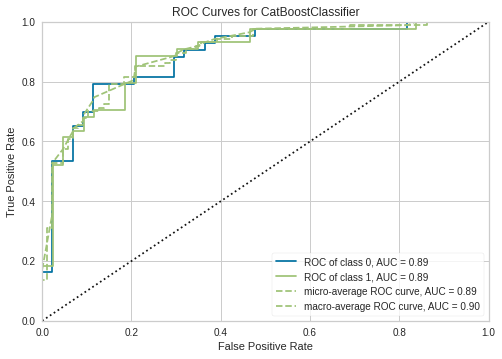

In [50]:
plot_model(tuned_catboost, plot = 'auc')

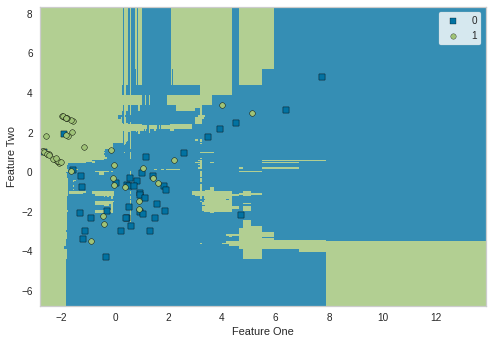

In [51]:
plot_model(tuned_catboost, plot = 'boundary')

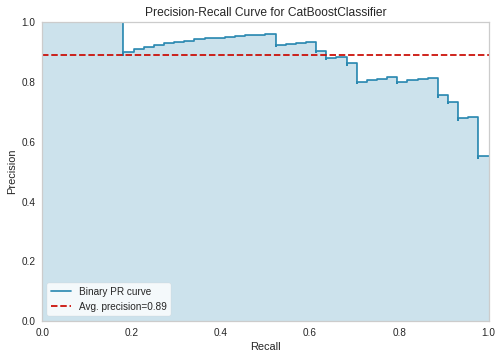

In [52]:
# Precision Recall Curve
plot_model(tuned_catboost, plot = 'pr')

# Submission

In [54]:
sub.head(2)

,PassengerId,Transported
0,0013_01,False
1,0018_01,False


In [60]:
y_pred = predict_model(tuned_catboost, data=test)
sub['Transported'] = y_pred['Label']
sub.to_csv("/home/mikhail/Downloads/sample_submission.csv'", index=False)
sub.head()

,PassengerId,Transported
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1


In [ ]:
# y_prob_3 = sum(y_probs_2) / len(y_probs_2)
# y_prob_3

# preds = []
# for i in y_prob_3:
#     if i[0] > i[1]:
#         preds.append(False)
#     else:
#         preds.append(True)
        
# def save_submission(y_pred):  
#     #classes = label.inverse_transform(y_pred)
#     sub["Transported"] = y_pred
#     #assert len(classes) == sub.shape[0]
#     assert 2 == sub.shape[1]   
#     sub.to_csv("/home/mikhail/Downloads/sample_submission.csv'", index=False)
#     return sub
# save_submission(preds_n).head(3)